In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import copy

from uncertainty_forest.uncertainty_forest import UncertaintyForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

In [13]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
import mixed

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

In [15]:
def cef_estimate_mike_1(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    tree_idx = 0
    for tree in model:
        
        # get out of bag indices.       
        # Here's where we obtain unsampled indices.
        # unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X), int((1 - max_samples)*len(X)))
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0,X.shape[0]), sampled_indices)
        tree_idx = tree_idx + 1
        # Done with unsampled indices.
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

In [16]:
def generate_data(n, d, K):
    X = np.random.uniform(0, 1, size = (n, d))
    y = np.random.randint(low=0, high=K, size=n)
    
    return X, y

In [17]:
def estimate_mi(X, y, label):
    _, counts = np.unique(y, return_counts=True)
    est_H_Y = entropy(counts, base=np.exp(1))
    
    if label == "IRF":
        frac_eval = 0.3
        irf = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5)
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        irf.fit(X_train, y_train)
        p = irf.predict_proba(X_eval)
        
        return (est_H_Y - np.mean(entropy(p.T, base = np.exp(1))))
    elif label == "UF":
        return (est_H_Y - cef_estimate_mike_1(np.array(X), y, 300, .32, depth = 30))
    elif label == "KSG":
        return mixed.KSG(X, y.reshape(-1, 1))
    elif label == "Mixed KSG":
        return mixed.Mixed_KSG(X, y.reshape(-1, 1))
    else:
        raise ValueError("Unrecognized Label!")

In [18]:
def get_mutual_info(elems, over, algos, n = 10, d = 2, K = 3):
    
    for j, algo in enumerate(algos):
        times = []
        for i, elem in enumerate(elems):
            
            # Generate data with the proper n, d, and K.
            if over == 'n':
                X, y = generate_data(elem, d, K)
            elif over == 'd':
                X, y = generate_data(n, elem, K)
            elif over == 'K':
                X, y = generate_data(n, d, elem)
            else:
                raise ValueError("Must compute over 'n', 'd', or 'K'.")

            # Compute time for algo for this setting.
            time = %timeit -n 1 -r 3 -q -o estimate_mi(X, y, algo['label'])
            times.append(np.mean(time.timings))
            
        output = np.array(times)
        if over == 'n':
            pickle.dump(elems, open('ns.pkl', 'wb'))
            pickle.dump(output, open('%s_by_n_d_%d_K_%d.pkl' % (algo['label'], d, K), 'wb'))
        elif over == 'd':
            pickle.dump(elems, open('ds.pkl', 'wb'))
            pickle.dump(output, open('%s_by_d_n_%d_K_%d.pkl' % (algo['label'], n, K), 'wb'))
        elif over == 'K':
            pickle.dump(elems, open('Ks.pkl', 'wb'))
            pickle.dump(output, open('%s_by_K_n_%d_d_%d.pkl' % (algo['label'], n, d), 'wb'))
        else:
            raise ValueError("Must compute over 'n', 'd', or 'K'.")

In [19]:
# Real params
ns = [
    200,
    500,
    1000,
    2000,
    5000,
    10000
]
ds = range(2, 41, 2)
Ks = range(2, 10, 1)
n = 5000
d = 4
K = 3

# Fake params
# ns = range(200, 301, 50)
# ds = range(2, 5, 1)
# Ks = range(2, 5, 1)
# n = 200
# d = 2
# K = 2

# Algorithms.
algos = [
    {
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
        'label': 'KSG',
        'title': 'KSG',
        'color': "#1b9e77",
    },
    {
        'label': 'Mixed KSG',
        'title': 'Mixed KSG',
        'color': "purple",
    },
    {
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

In [9]:
get_mutual_info(ns, 'n', algos, d = d, K = K)

In [10]:
get_mutual_info(ds, 'd', algos, n = n, K = K)

In [11]:
get_mutual_info(Ks, 'K', algos, n = n, d = d)

In [20]:
def plot_mutual_info(ax, over, algos, n = 10, d = 2, K = 3):
    # Generate data with the proper n, d, and K.
    if over == 'n':
        xs = pickle.load(open('ns.pkl', 'rb'))
        ax.set_title('d = %d, K = %d' % (d, K))
        ax.set_xlabel("Sample Size")
    elif over == 'd':
        xs = pickle.load(open('ds.pkl', 'rb'))
        ax.set_title('n = %d, K = %d' % (n, K))
        ax.set_xlabel("Dimensionality")
    elif over == 'K':
        xs = pickle.load(open('Ks.pkl', 'rb'))
        ax.set_title('n = %d, d = %d' % (n, d))
        ax.set_xlabel("Number of Classes")
    else:
        raise ValueError("Must compute over 'n', 'd', or 'K'.")
        
    for j, algo in enumerate(algos):
        if over == 'n':
            ys = pickle.load(open('%s_by_n_d_%d_K_%d.pkl' % (algo['label'], d, K), 'rb'))
        elif over == 'd':
            ys = pickle.load(open('%s_by_d_n_%d_K_%d.pkl' % (algo['label'], n, K), 'rb'))
        elif over == 'K':
            ys = pickle.load(open('%s_by_K_n_%d_d_%d.pkl' % (algo['label'], n, d), 'rb'))
        else:
            raise ValueError("Must compute over 'n', 'd', or 'K'.")
        ax.plot(xs,
                ys, 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])

    ax.set_xlim(left = np.amin(xs) - 0.05)
    ax.set_xlim(right = np.amax(xs) + 0.05)

In [21]:
def plot_fig8(algos, n, d, K):
    sns.set(font_scale = 2.5)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    fig, axes = plt.subplots(1, 3, figsize = (25,10))

    plot_mutual_info(axes[0], 'n', algos, d = d, K = K)
    plot_mutual_info(axes[1], 'd', algos, n = n, K = K)
    plot_mutual_info(axes[2], 'K', algos, n = n, d = d)
        
    axes[2].legend(loc = "upper right")
    axes[0].set_ylabel("Time Taken")

    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.tight_layout()
    plt.savefig("fig9.pdf")
    plt.show()

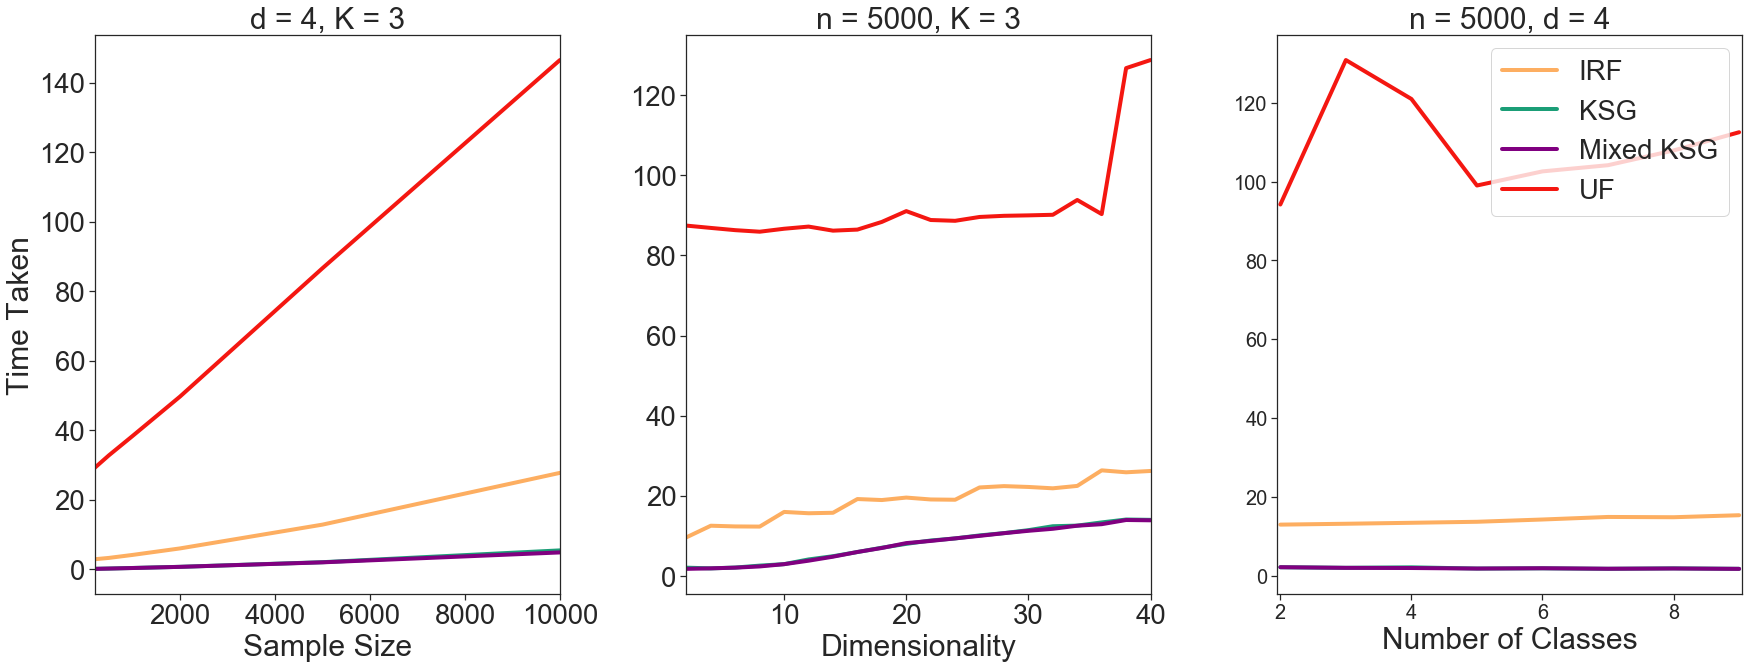

In [22]:
plot_fig8(algos, n, d, K)